#### Explore the ready dataset Iisights,distribution,charachtristics ...

In [1]:

from modbus import ModbusDataset
import pandas as pd 
import re   
# import torch
from torch.utils.data import Dataset
from torch import Tensor,tensor,float32,int32
import numpy as np
# import json
from utils import merge_datasets
from collections import Counter
import matplotlib.pyplot as plt
import os 
from typing import List, Tuple
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler


In [ ]:
# uncommit if the Labeled_CICMODBUS2023.zip not extracted yet! 
# import zipfile
# import os

# # from Labeling notebook , This file will be achieved.
# zip_path = "./Labeled_CICMODBUS2023.zip"
# extract_dir = "./dataset"

# # Create directory if missing
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)



In [2]:
dataset_directory = "./dataset" # change this to the folder contain benign and attack subdirs
modbus = ModbusDataset(dataset_directory,"ready",batch_size=5)
modbus.summary_print()

 The CIC Modbus Dataset contains network (pcap) captures and attack logs from a simulated substation network.
                The dataset is categorized into two groups: an attack dataset and a benign dataset
                The attack dataset includes network traffic captures that simulate various types of Modbus protocol attacks in a substation environment.
                The attacks are reconnaissance, query flooding, loading payloads, delay response, modify length parameters, false data injection, stacking Modbus frames, brute force write and baseline replay.
                These attacks are based of some techniques in the MITRE ICS ATT&CK framework.
                On the other hand, the benign dataset consists of normal network traffic captures representing legitimate Modbus communication within the substation network.
                The purpose of this dataset is to facilitate research, analysis, and development of intrusion detection systems, anomaly detection algorithms and

In [3]:
def find_global_stats(csv_files,category,return_fitted_scalers=False,unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp']):
    """
    Analyzes multiple CSV files, grouped by their subdirectory, to calculate global statistics
    (count, mean, std, min, max, duplicates) for numeric features and label counts for the 'Label' column.
    It can also return and save fitted MinMaxScaler and StandardScaler objects for future use.

    Args:
        csv_files (list): CSV dataset files to be analyzed.
        category (str): A string representing the category of the Attack scenario 
        return_fitted_scalers (bool, optional): If True, the function will return a dictionary
                                                of fitted MinMaxScaler and StandardScaler objects
                                                for each numeric column and save them to disk.
                                                Defaults to False.
        unuseful_features (list, optional): A list of column names to be excluded from the
                                            numeric feature analysis. Defaults to
                                            ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'].

    Returns:
        tuple: A tuple containing:
            - all_global_stats (dict): A nested dictionary where the first level keys are
                                       subdirectory names. The second level contains another
                                       dictionary with numeric column names as keys, and
                                       their calculated statistics (count, mean, std, min, max, duplicates)
                                       as values.
            - all_label_counts (dict): A dictionary where keys are subdirectory names and values
                                       are dictionaries of label counts for the 'Label' column
                                       within each subdirectory's files.
            - all_fitted_scalers (dict, optional): Returned only if `return_fitted_scalers` is True.
                                                  A dictionary where keys are subdirectory names,
                                                  and values are dictionaries containing fitted
                                                  MinMaxScaler and StandardScaler objects for each
                                                  numeric column.
            - numeric_cols (list, optional): Returned only if `return_fitted_scalers` is True.
                                            A list of the numeric columns for which statistics
                                            and scalers were calculated.
    """
    print("-"*40,category,"-"*40)
    # Group files by their subdirectory
    dir_groups = {}
    for file in csv_files:
        subdir = os.path.basename(os.path.dirname(os.path.dirname(file)))
        # Clean subdirectory name by removing '-network-capture' and '-wide-pcap-capture'
        subdir = re.sub(r'-(network|wide)-(pcap-)?capture(s?)', '', subdir)
        if subdir not in dir_groups:
            dir_groups[subdir] = []
        dir_groups[subdir].append(file)
    
    all_global_stats = {}
    all_label_counts = {}
    if return_fitted_scalers:
        all_fitted_scalers = {} # To store the fitted MinMaxScaler and StandardScaler instances
        # Define the directory to save fitted scalers
        scalers_save_dir = 'fitted_scalers'
        os.makedirs(scalers_save_dir, exist_ok=True) # Create the directory if it doesn't exist

    for subdir, files in dir_groups.items():
        # Read first file to get numeric columns
        first_df = pd.read_csv(files[0], encoding='cp1252')
        numeric_cols = first_df.drop(columns=unuseful_features, errors='ignore').select_dtypes(include=['number']).columns.tolist()
        # Initialize trackers for statistics
        stats = {
            col: {
                'count': 0, 
                'sum': 0.0, 
                'sum_sq': 0.0, 
                'min': float('inf'), 
                'max': float('-inf'),
                'duplicates': 0,
            } for col in numeric_cols
        }
        
        # Initialize counter for Label column
        label_counts = Counter()
        # To track unique values for duplicates calculation
        unique_values = {col: set() for col in numeric_cols}
        len_csv_files = len(files)

        # Initialize scalers for each numeric column.
        # partial_fit allows incremental fitting, suitable for processing data in chunks.
        min_max_scalers = {col: MinMaxScaler() for col in numeric_cols}
        standard_scalers = {col: StandardScaler() for col in numeric_cols}

        for file_index,file in enumerate(files):
            # Read only necessary columns (numeric_cols + Label)
            print("node : ",subdir,", file_",file_index+1,"/",len_csv_files,":",file)
            df = pd.read_csv(file, encoding='cp1252', usecols=numeric_cols + ['Label'], low_memory=False)
            # Count labels in the current file
            if 'Label' in df.columns:
                label_counts.update(df['Label'])
            
            for col in numeric_cols:
                # Track unique values for duplicates
                current_values = set(df[col])
                stats[col]['duplicates'] += len(df[col]) - len(current_values - unique_values[col])
                unique_values[col].update(current_values)
                
                # Update other statistics (only for non-NaN values)
                valid_data = df[col]
                data_to_fit = valid_data.values.reshape(-1, 1) # Reshape for scikit-learn
                min_max_scalers[col].partial_fit(data_to_fit)
                standard_scalers[col].partial_fit(data_to_fit)
                
        
        # Compute final statistics for numeric columns
        feature = {}
        for col in numeric_cols:
            mm_scaler = min_max_scalers[col]
            std_scaler = standard_scalers[col]
            # The 'n_samples_seen_' attribute from StandardScaler gives the total count of samples seen
            sk_count = std_scaler.n_samples_seen_
            sk_mean = std_scaler.mean_[0]
            sk_std = np.sqrt(std_scaler.var_[0]) # Standard deviation is the square root of variance
            # Extract min and max from MinMaxScaler
            sk_min_val = mm_scaler.data_min_[0]
            sk_max_val = mm_scaler.data_max_[0]

            feature[col] = {
                'count':sk_count,
                'mean': sk_mean,
                'std': sk_std,
                'min': sk_min_val,
                'max': sk_max_val,
                'duplicates': stats[col]['duplicates']/ sk_count  
            }

        
        # Store results for this subdirectory
        all_global_stats[subdir] = feature
        all_label_counts[subdir] = dict(label_counts)
        # Store the fitted scaler objects for later use in scaling new data
        if return_fitted_scalers:
            all_fitted_scalers[subdir] = {
                'min_max_scalers': min_max_scalers,
                'standard_scalers': standard_scalers
            }

    if return_fitted_scalers:    
        return all_global_stats, all_label_counts ,all_fitted_scalers,numeric_cols
    else:
        return all_global_stats, all_label_counts


def print_statistics(_global_stats):

    for index, _global_stat in enumerate(_global_stats):
        global_stats_df = pd.DataFrame(_global_stats[_global_stat]).transpose()
        print("-"*80,"\nnode_", index," :",_global_stat,"\nflows count_",global_stats_df['count'].iloc[0])

        # Display with all rows and columns visible
        with pd.option_context('display.max_rows', None, 
                            'display.max_columns', None, 
                            'display.width', None,
                            'display.float_format', '{:.2f}'.format):  # Adjust decimal places as needed
            print(global_stats_df.drop(columns=['count']))
def plot_label_counts_subplots(all_label_counts):
    n_subdirs = len(all_label_counts)
    ncols = 2  
    nrows = (n_subdirs + 1) // 2  
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), squeeze=False)
    axes = axes.flatten() 
    
    # Plot each subdirectory's label counts
    for idx, (subdir, label_counts) in enumerate(all_label_counts.items()):
        labels = list(label_counts.keys())
        counts = list(label_counts.values())
        
        bars = axes[idx].bar(labels, counts, color=['#36A2EB', '#FF6384', '#FFCE56', '#4BC0C0', '#9966FF'][:len(labels)])
        axes[idx].set_title(f'Label Distribution: {subdir}')
        axes[idx].set_xlabel('Labels')
        axes[idx].set_ylabel('Count')
        # Increase rotation and adjust font size to reduce overlap
        axes[idx].tick_params(axis='x', rotation=60, labelsize=8)
        
        # Add count numbers on top of each bar
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2,  
                height,  #
                f'{int(height)}',  
                ha='center',  
                va='bottom', 
                fontsize=9
            )
    axes[idx].set_ylim(0, max(counts) * 1.15)
    # Hide any unused subplots
    for idx in range(len(all_label_counts), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

#### the ICS statistics and label distribution


- Extract min, max, mean , std and duplicate ratio for each numerical feature
- Duplicates are between 0 and 1 (from no duplicate  to nearly almost)
- Calculate global min max of benign dataset numeric values for later min_max scaling 

In [4]:
# #pre calculated numeric_cols with the enhanced CICFlowMeter 2019 
numeric_cols = ['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Bwd Act Data Pkts', 'Fwd Seg Size Min', 'Bwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'ICMP Code', 'ICMP Type', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time']
# ### needed for scaling  (will change numeric_cols)
benign_global_stats, benign_label_counts,benign_scalers,numeric_cols= find_global_stats(modbus.dataset["benign_dataset_dir"],"benign",return_fitted_scalers=True)


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

In [13]:
import os
import re
import random
from typing import List, Tuple
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch import tensor, float32, int32
from collections import Counter
import numpy as np # Used for np.ceil

class CSVDataset(Dataset):
    def __init__(
        self,
        csv_files: List[str],
        chunk_size: int = 5,
        # batch_size: int = 64, # Removed as it's fixed internally now
        scalers: dict = None  # Changed to accept a dictionary of scalers
    ):
        """
        Custom PyTorch Dataset for reading multiple CSV files in chunks with preprocessing and scaling.

        Args:
            csv_files: List of paths to CSV files
            chunk_size: Number of files to process in one chunk (default: 5)
            scalers: Dictionary of fitted scalers (MinMaxScaler or StandardScaler) for each numeric feature column.
        """
        self.csv_files = csv_files
        self.csv_files_len = len(csv_files)
        self.chunk_size = chunk_size
        self.batch_size = 64  # Fixed internal batch size as per requirement
        self.label_column = 'Label'
        self.protocol_column = 'Protocol'
        self.scalers = scalers  # Store the dictionary of scalers

        # For managing file order and shuffling across epochs
        self.file_order_indices = list(range(self.csv_files_len))
        random.shuffle(self.file_order_indices) # Initial shuffle of file indices
        self.current_file_idx = 0 # This index points into self.file_order_indices

        self.current_chunk_data = None
        self.current_chunk_labels = None
        self.current_row_in_chunk_idx = 0 # Index within the currently loaded chunk

        self.unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp','end_time']

        # Initialize LabelEncoder and OneHotEncoder
        self.label_encoder = LabelEncoder()
        # OneHotEncoder for 'Protocol' column: handles unknown categories by ignoring them, returns dense array
        self.protocol_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self._fit_encoders()

        # Precalculate total rows and total batches
        self.total_samples = self._calculate_total_rows()
        self.total_batches = int(np.ceil(self.total_samples / self.batch_size))

        self._load_next_chunk() # Load the first chunk of data

    def _fit_encoders(self):
        """
        Fit LabelEncoders for 'Label' and OneHotEncoder for 'Protocol' based on known unique values.
        """
        label_values = ['BASELINE REPLAY', 'PAYLOAD INJECTION', 'FRAME STACKING', 'QUERY FLOODING', 'RECON',
                        'BRUTE FORCE', 'BENIGN', 'DELAY RESPONSE', 'LENGTH MANIPULATION']
        # OneHotEncoder expects a 2D array, even for a single feature
        protocol_values = np.array([17, 2, 6]).reshape(-1, 1)
        self.label_encoder.fit(label_values)
        self.protocol_encoder.fit(protocol_values)

    def _preprocess_chunk(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply scaling to numeric columns using the provided dictionary of scalers.

        Args:
            df (pd.DataFrame): The DataFrame chunk to preprocess.

        Returns:
            pd.DataFrame: The preprocessed DataFrame.
        """
        # Identify numeric columns, excluding label and the original protocol column
        numeric_cols = [col for col in df.columns if col not in [self.label_column, self.protocol_column]]

        if self.scalers:
            for col in numeric_cols:
                if col in self.scalers: # Ensure a scaler exists for the current column
                    # Apply the specific scaler for this column
                    # .transform expects a 2D array, hence df[[col]]
                    df[col] = self.scalers[col].transform(df[[col]])
        return df

    def _load_next_chunk(self):
        """
        Loads the next chunk of CSV files into memory based on the shuffled file indices,
        preprocesses, encodes, and converts data to PyTorch Tensors.
        Handles reshuffling of file indices when all files have been processed (end of an internal "epoch").
        """
        # If all files from the current shuffled order have been processed, reshuffle for the next epoch
        if self.current_file_idx >= self.csv_files_len:
            self.file_order_indices = list(range(self.csv_files_len))
            random.shuffle(self.file_order_indices)
            self.current_file_idx = 0 # Reset file index for the new shuffled order

        start_idx_in_order = self.current_file_idx
        end_idx_in_order = min(start_idx_in_order + self.chunk_size, self.csv_files_len)

        # Get the actual file paths for the current chunk using the shuffled indices
        chunk_file_paths = [self.csv_files[self.file_order_indices[i]] for i in range(start_idx_in_order, end_idx_in_order)]

        if chunk_file_paths:
            # Read CSV files, dropping unuseful features
            dfs = [pd.read_csv(file, encoding='cp1252', usecols=lambda column: column not in self.unuseful_features, low_memory=False) for file in chunk_file_paths]
            chunk_df = pd.concat(dfs, ignore_index=True)

            chunk_df[self.label_column] = self.label_encoder.transform(chunk_df[self.label_column])

            # One-Hot Encode 'Protocol' column and add new columns
            # .transform expects a 2D array, hence chunk_df[[self.protocol_column]]
            protocol_encoded = self.protocol_encoder.transform(chunk_df[[self.protocol_column]].values)

            protocol_df = pd.DataFrame(protocol_encoded, columns=['Protocol_2', 'Protocol_6', 'Protocol_17'])
            # Drop the original 'Protocol' column and concatenate the new one-hot encoded columns
            chunk_df = pd.concat([chunk_df.drop(columns=[self.protocol_column]), protocol_df], axis=1)

            # Apply preprocessing (scaling) to numeric features
            chunk_df = self._preprocess_chunk(chunk_df)

            feature_cols = [col for col in chunk_df.columns if col not in [self.label_column]]

            print(feature_cols)
            self.current_chunk_data = tensor(chunk_df[feature_cols].values, dtype=float32)
            self.current_chunk_labels = tensor(chunk_df[self.label_column].values, dtype=int32)

            self.current_file_idx = end_idx_in_order
            self.current_row_in_chunk_idx = 0  # Reset row index within the new chunk
        else:
            self.current_chunk_data = None
            self.current_chunk_labels = None

    def _calculate_total_rows(self) -> int:
        """
        Calculates the total number of samples across all CSV files.
        This is called once during initialization.
        """
        total_rows = 0
        for file in self.csv_files:
            # Read only the label column to quickly get the row count
            df = pd.read_csv(file, usecols=[self.label_column], encoding='cp1252', low_memory=False)
            total_rows += len(df)
        return total_rows

    def __len__(self) -> int:
        """
        Returns the total number of batches available for a DataLoader with batch_size=1.
        This value is precalculated in the __init__ method.
        """
        return self.total_batches

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """
        Returns a batch of data and labels as tensors.
        This method internally manages loading fixed-size batches (self.batch_size=64) from chunks.
        The `idx` parameter from DataLoader is used by DataLoader for tracking progress,
        but not directly for selecting data within this Dataset's internal logic.

        Args:
            idx (int): Index provided by the DataLoader.

        Returns:
            Tuple[Tensor, Tensor]: A tuple containing (features_tensor, labels_tensor) for the batch.
        """
        if self.current_chunk_data is None:
            # If current_chunk_data is None, it means there are no more files to process
            # in the current shuffled order (or globally). This signals end of iteration.
            raise StopIteration("No more data chunks to load.")

        current_len_chunk_data = len(self.current_chunk_data)

        # Calculate the end index for the current batch within the current chunk.
        # It takes `self.batch_size` samples, or fewer if close to the end of the chunk.
        end_idx = min(self.current_row_in_chunk_idx + self.batch_size, current_len_chunk_data)

        # Slice the data and labels directly from the pre-converted tensors
        features = self.current_chunk_data[self.current_row_in_chunk_idx:end_idx]
        labels = self.current_chunk_labels[self.current_row_in_chunk_idx:end_idx]

        # Update the starting index for the next batch within the current chunk
        self.current_row_in_chunk_idx = end_idx

        # If we have processed all rows in the current chunk, load the next chunk of files
        if self.current_row_in_chunk_idx >= current_len_chunk_data:
            self._load_next_chunk() # This call will also handle reshuffling for the next epoch if needed

        return features, labels



In [ ]:
dataset = CSVDataset(csv_files=modbus.dataset["attack_dataset_dir"]["external"][0:2], chunk_size=5, scalers=benign_scalers)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(f"Total batches in the dataset: {len(dataloader)}")
num_epochs = 3 # Example: Train for 3 epochs

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")
    for batch_idx, (features, labels) in enumerate(dataloader):
        # 'features' will be a tensor of shape (batch_size, num_features)
        # 'labels' will be a tensor of shape (batch_size,)
        # Where batch_size is 64 (or less for the final batch in a chunk/dataset)

        print(f"  Batch {batch_idx + 1}: Features {features[0][0][0]}, Labels shape={labels.shape}")

        # Your training logic would go here:
        # 1. Pass features through your model
        # 2. Calculate loss
        # 3. Perform backpropagation and optimization step
        # For demonstration, we'll just print shapes.

        # Example of how you might check for the end of the dataset
        # The DataLoader will handle StopIteration automatically
        # if batch_idx >= len(dataloader) - 1:
        #     print("End of dataset reached for this epoch.")
        #     break


['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:

# ###(just for visualization) Uncomment if you want to create the attack plots and statistic tables on your own.

# attack_global_stats, attack_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["total"],"attack")
# ext_global_stats, ext_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["external"],"external")
# com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
# com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

##### benign 

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 2822444.0
                                  mean          std   min            max  \
Protocol                          6.00         0.16  2.00          17.00   
Flow Duration              10297843.17  26824472.17  0.00   119999783.00   
Total Fwd Packet                  4.27         2.50  0.00         226.00   
Total Bwd packets                 3.30         1.65  0.00         210.00   
Total Length of Fwd Packet       17.41       189.83  0.00       52116.00   
Total Length of Bwd Packet        7.97        14.79  0.00        3914.00   
Fwd Packet Length Max             9.21        14.84  0.00         700.00   
Fwd Packet Length Min             0.01         1.08  0.00         118.00   
Fwd Packet Length Mean            1.92         7.00  0.00         230.60   
Fwd Packet Length Std             3.97         7.45  0.00         350.00   
Bwd Packet Length Max             

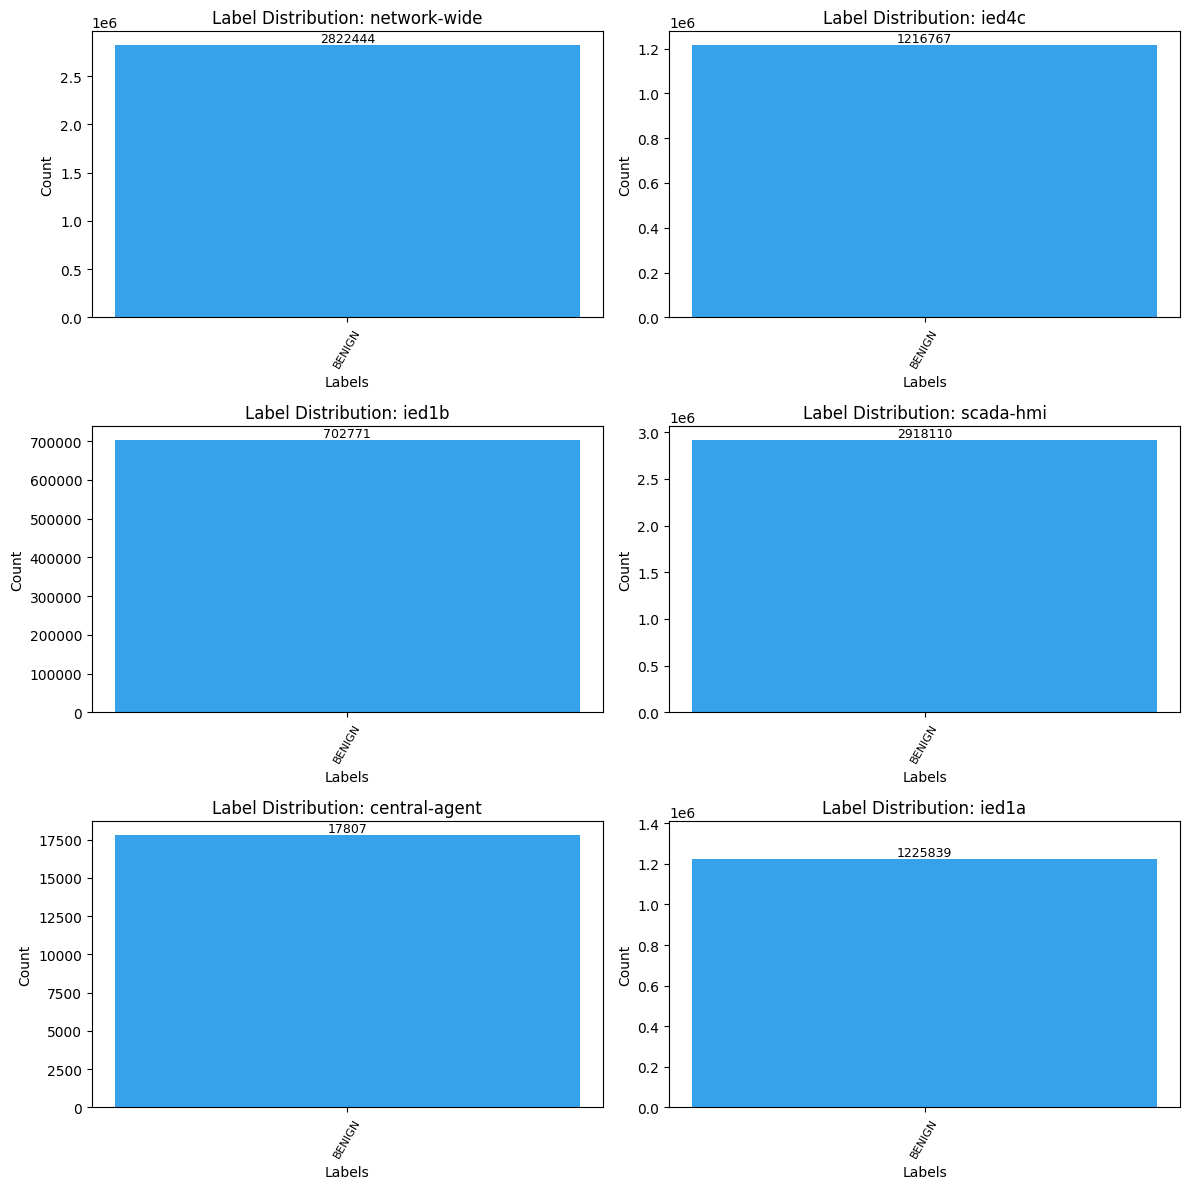

In [5]:

print_statistics(benign_global_stats)
plot_label_counts_subplots(benign_label_counts)


##### total attacks

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 221329.0
                                  mean          std   min            max  \
Protocol                          6.00         0.13  2.00          17.00   
Flow Duration               7108321.29  22696854.83  0.00   119612092.00   
Total Fwd Packet                  4.26         2.12  0.00         244.00   
Total Bwd packets                 3.46         1.42  0.00         126.00   
Total Length of Fwd Packet       15.06       148.64  0.00       31874.00   
Total Length of Bwd Packet        5.53        12.18  0.00        2394.00   
Fwd Packet Length Max             9.95        12.26  0.00         276.00   
Fwd Packet Length Min             0.01         0.89  0.00         118.00   
Fwd Packet Length Mean            2.20         5.83  0.00         131.83   
Fwd Packet Length Std             4.51         6.23  0.00         146.07   
Bwd Packet Length Max             5

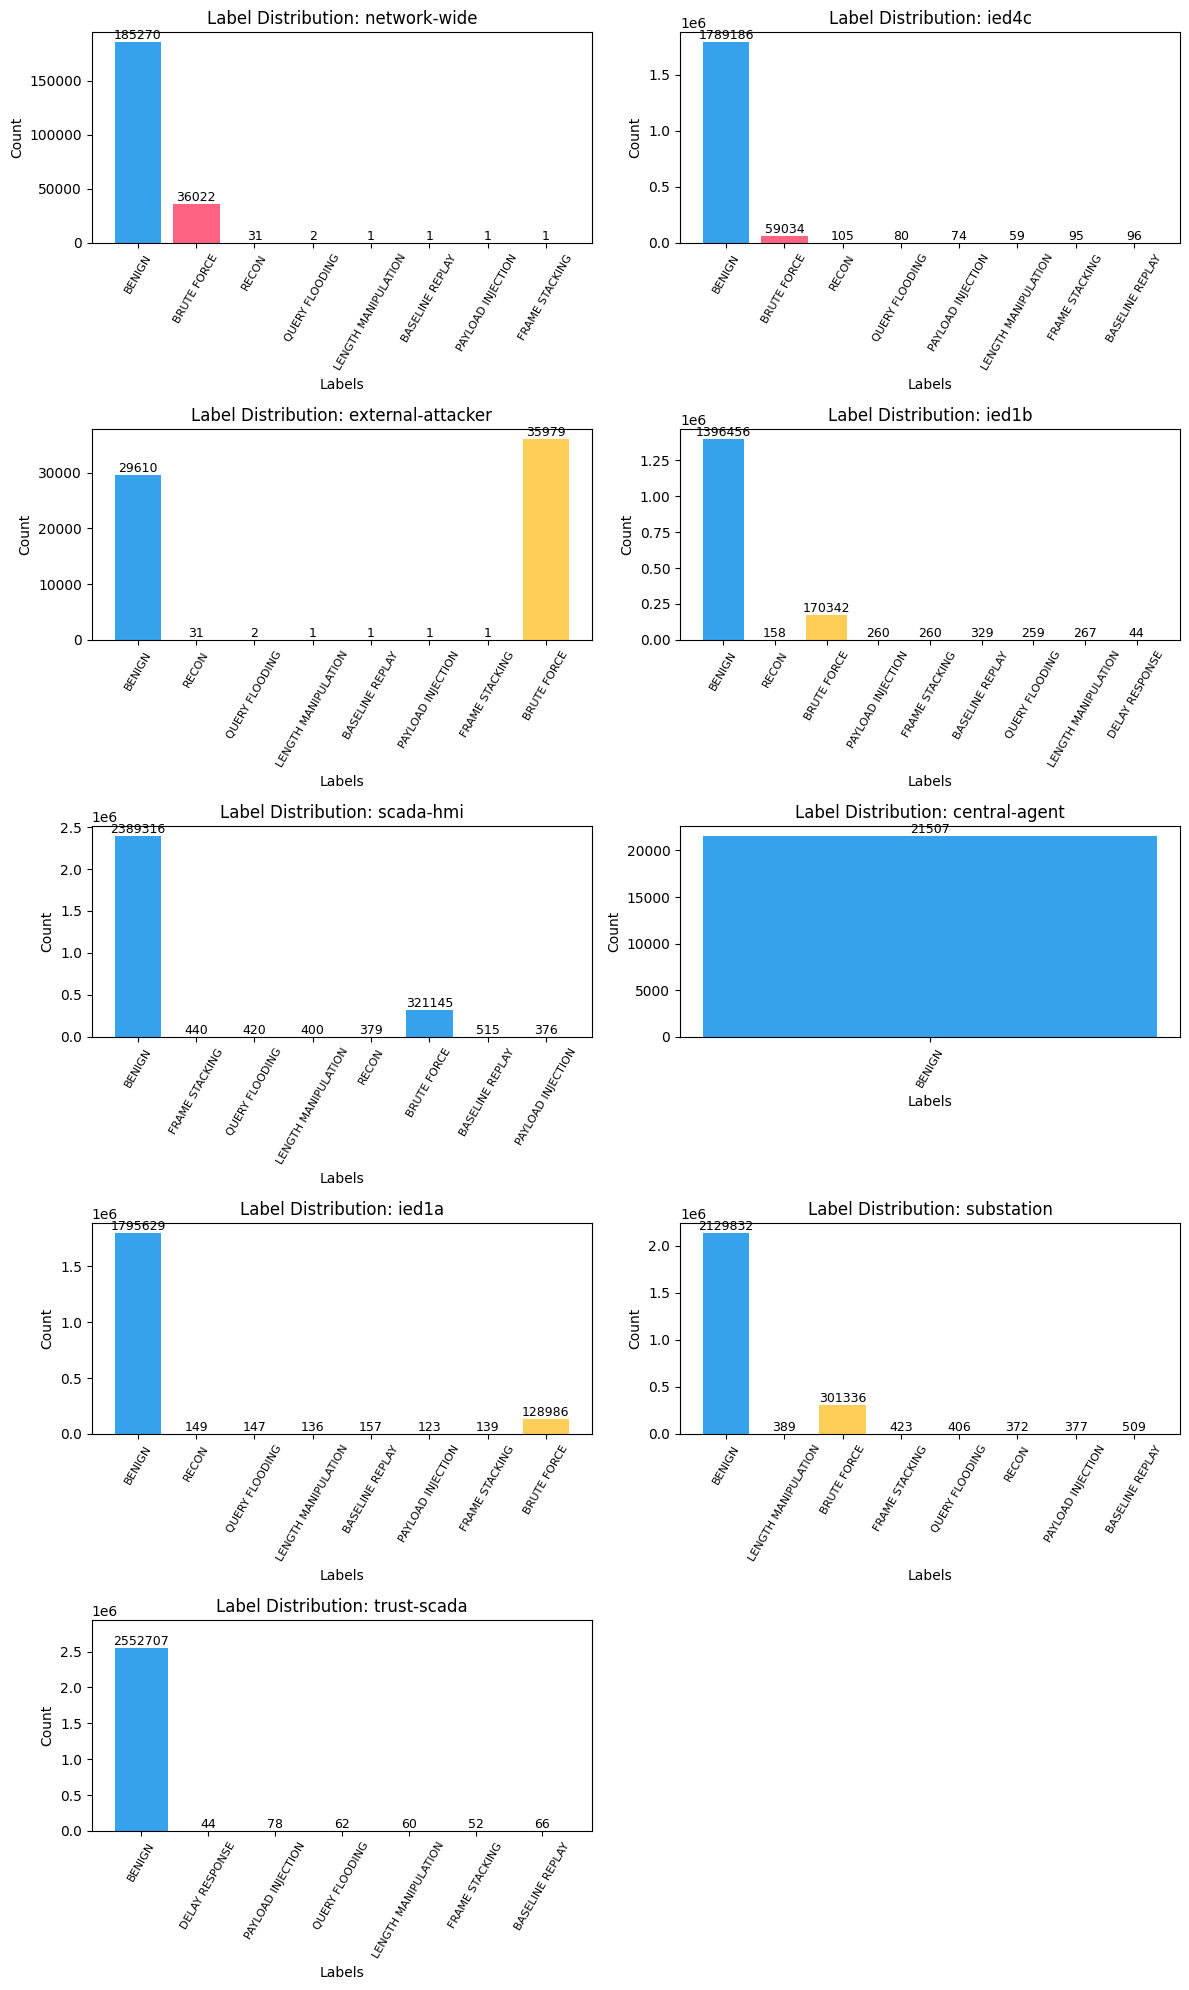

In [6]:

print_statistics(attack_global_stats)
plot_label_counts_subplots(attack_label_counts)


#### external 

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 221329.0
                                  mean          std   min            max  \
Protocol                          6.00         0.13  2.00          17.00   
Flow Duration               7108321.29  22696854.83  0.00   119612092.00   
Total Fwd Packet                  4.26         2.12  0.00         244.00   
Total Bwd packets                 3.46         1.42  0.00         126.00   
Total Length of Fwd Packet       15.06       148.64  0.00       31874.00   
Total Length of Bwd Packet        5.53        12.18  0.00        2394.00   
Fwd Packet Length Max             9.95        12.26  0.00         276.00   
Fwd Packet Length Min             0.01         0.89  0.00         118.00   
Fwd Packet Length Mean            2.20         5.83  0.00         131.83   
Fwd Packet Length Std             4.51         6.23  0.00         146.07   
Bwd Packet Length Max             5

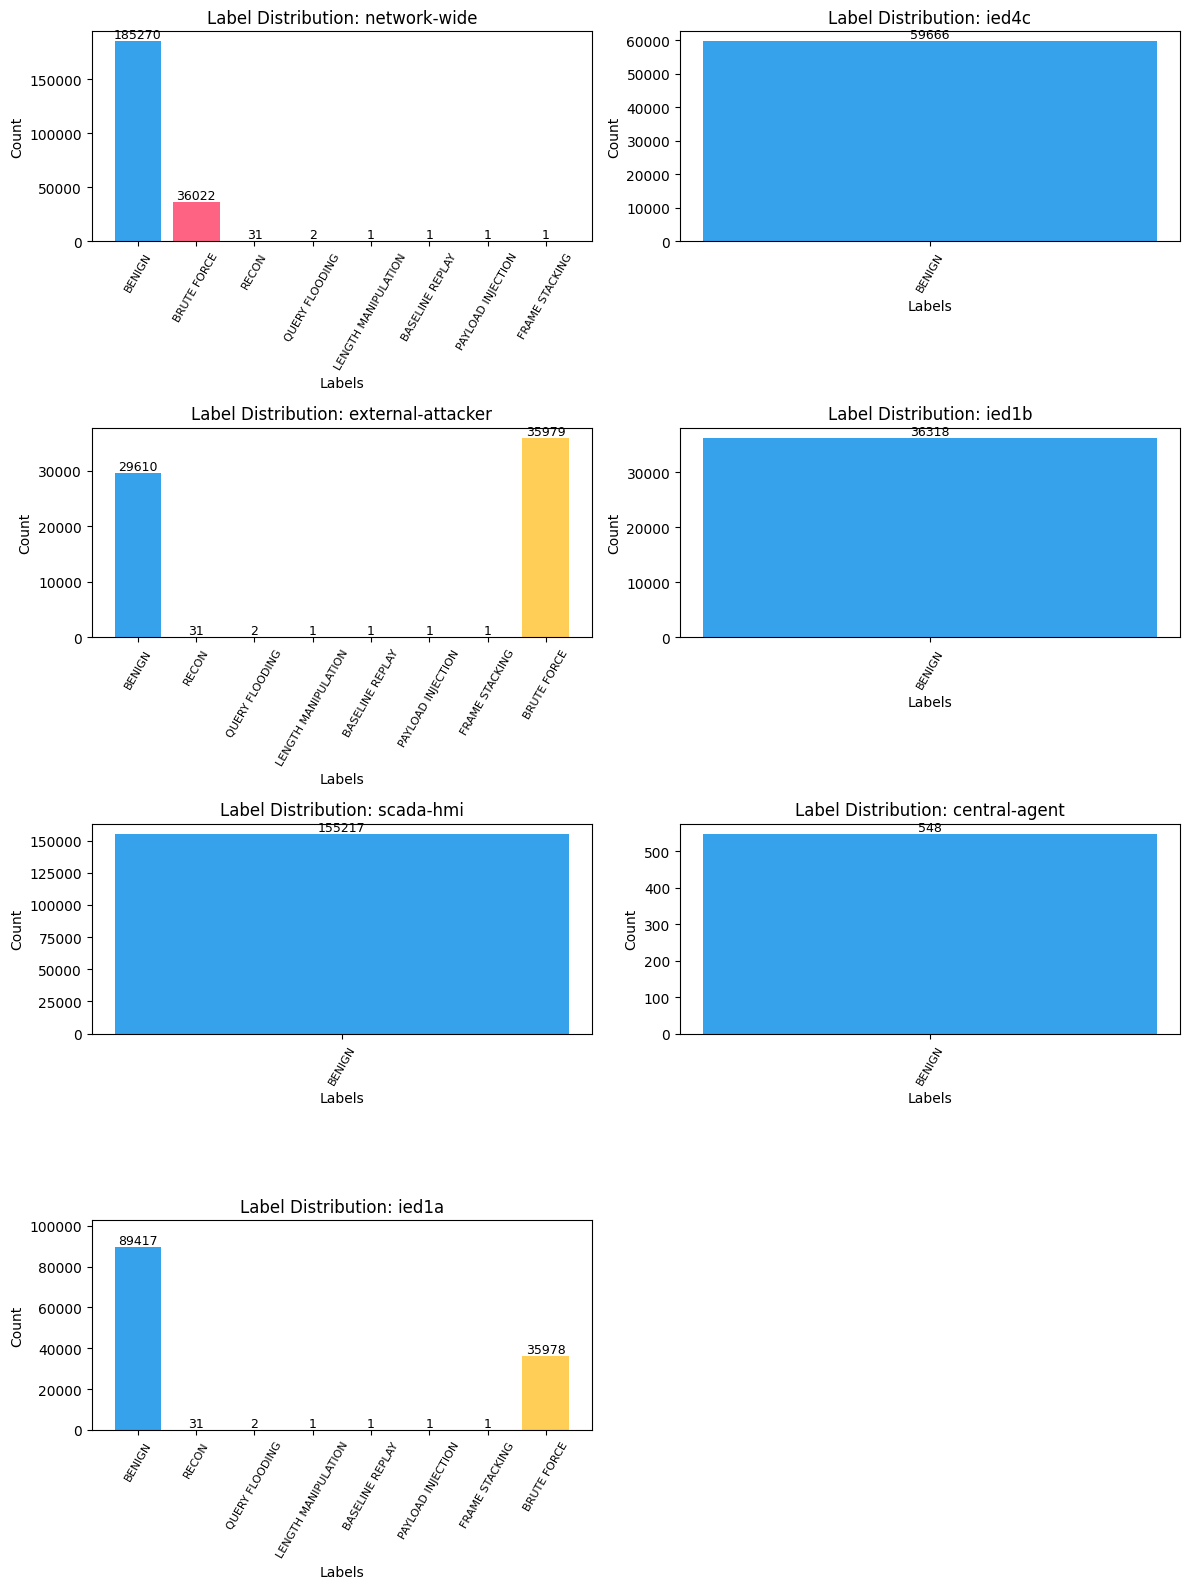

In [7]:

print_statistics(ext_global_stats)
plot_label_counts_subplots(ext_label_counts)


#### compromised ied 

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 949637.0
                                   mean          std   min            max  \
Protocol                           6.01         0.25  2.00          17.00   
Flow Duration               11306483.16  28013926.62  0.00   119990244.00   
Total Fwd Packet                   3.62         2.57  0.00         118.00   
Total Bwd packets                  2.98         1.79  0.00          61.00   
Total Length of Fwd Packet        18.42       207.76  0.00       15409.00   
Total Length of Bwd Packet         6.97        16.16  0.00        1159.00   
Fwd Packet Length Max              8.11        16.80  0.00         700.00   
Fwd Packet Length Min              0.03         1.71  0.00         118.00   
Fwd Packet Length Mean             1.89         8.33  0.00         175.00   
Fwd Packet Length Std              3.60         8.49  0.00         350.00   
Bwd Packet Length Max          

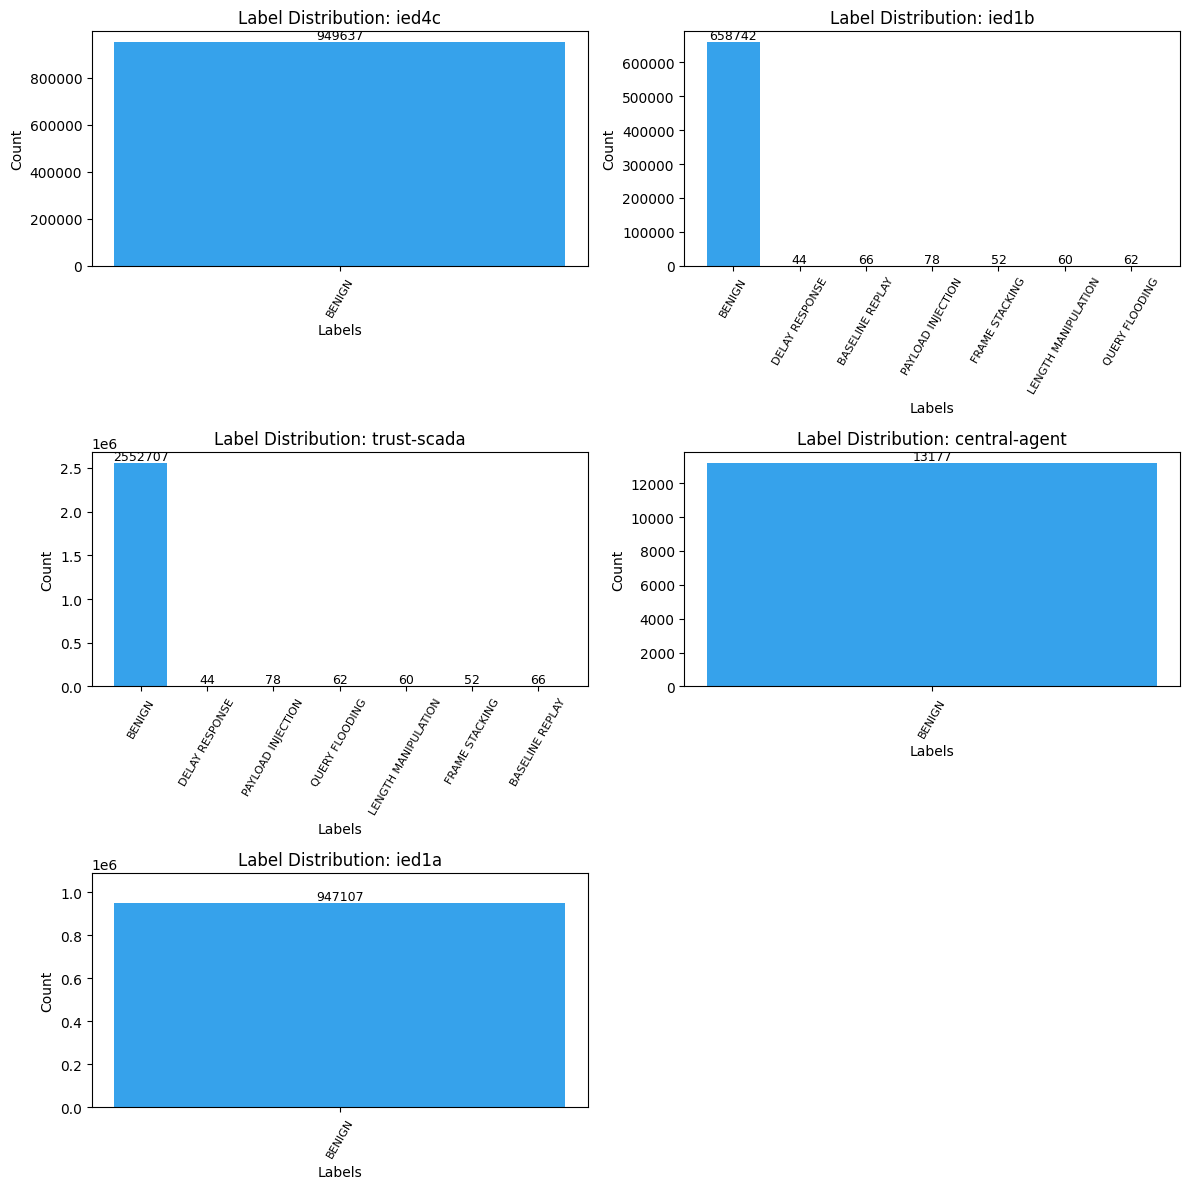

In [8]:

print_statistics(com_ied_global_stats)
plot_label_counts_subplots(com_ied_label_counts)


####compromised scada

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 839426.0
                                   mean           std   min             max  \
Protocol                           6.01          0.27  2.00           17.00   
Flow Duration               10097713.06   25868605.09  0.00    119999661.00   
Total Fwd Packet                   3.90          5.57  0.00          182.00   
Total Bwd packets                  3.14          3.12  0.00           99.00   
Total Length of Fwd Packet        46.01        711.73  0.00        25021.00   
Total Length of Bwd Packet         8.15         53.48  0.00         1881.00   
Fwd Packet Length Max              8.55         16.99  0.00          718.00   
Fwd Packet Length Min              0.04          1.88  0.00          118.00   
Fwd Packet Length Mean             2.04          8.51  0.00          179.50   
Fwd Packet Length Std              3.83          8.40  0.00          359.00   
Bwd Packe

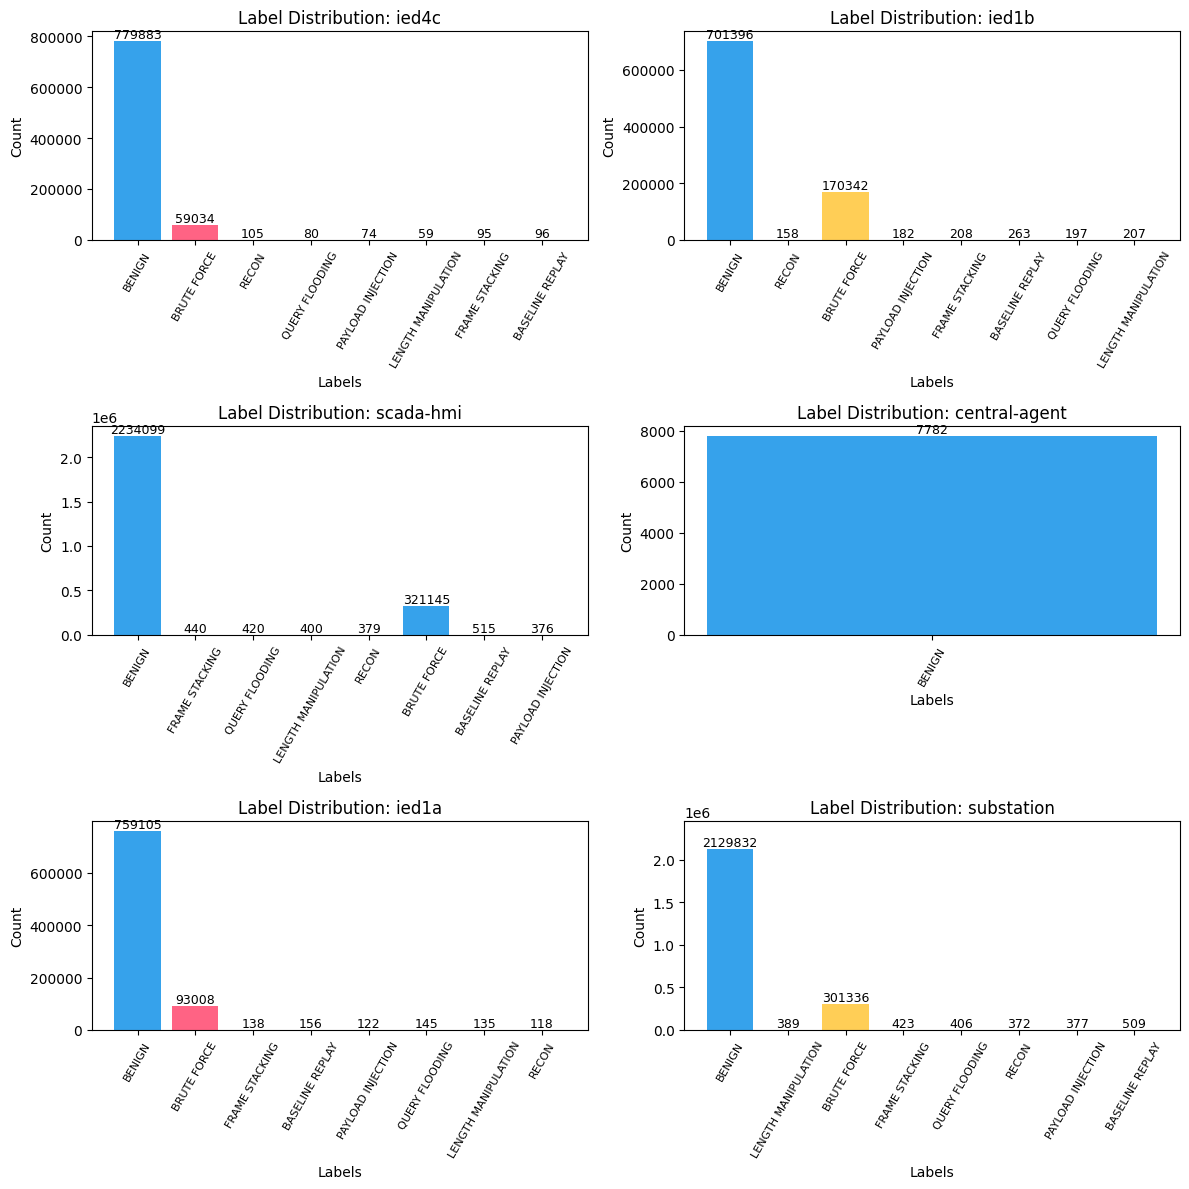

In [9]:

print_statistics(com_scd_global_stats)
plot_label_counts_subplots(com_scd_label_counts)


In [ ]:
class CSVDataset(Dataset):
    def __init__(
        self,
        csv_files: List[str],
        chunk_size: int = 5,
        batch_size: int = 64,
        min_max_scaler: MinMaxScaler = None,
        standard_scaler: StandardScaler = None
    ):
        """
        Custom PyTorch Dataset for reading multiple CSV files in chunks with preprocessing and scaling.
        
        Args:
            csv_files: List of paths to CSV files
            chunk_size: Number of files to process in one chunk (default: 5)
            batch_size: Desired batch size (default: 64)
            min_max_scaler: Fitted MinMaxScaler for numeric features
            standard_scaler: Fitted StandardScaler for numeric features
        """
        self.csv_files = csv_files
        self.csv_files_len = len(csv_files)
        self.chunk_size = chunk_size
        self.batch_size = batch_size
        self.label_column = 'Label'
        self.protocol_column = 'Protocol'
        self.min_max_scaler = min_max_scaler 
        self.standard_scaler = standard_scaler
        self.current_chunk = []
        self.current_file_idx = 0
        self.current_row_idx = 0
        self.current_df = None
        self.unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp']


        # Initialize LabelEncoders for consistent encoding
        self.label_encoder = LabelEncoder()
        self.protocol_encoder = LabelEncoder()
        self._fit_encoders()
        self._load_next_chunk()

    def _fit_encoders(self):
        """Fit LabelEncoders on all unique values founded by def find_unique_values()  
            for label and protocol columns across all CSV files."""
        label_values = ['BASELINE REPLAY', 'PAYLOAD INJECTION', 'FRAME STACKING', 'QUERY FLOODING', 'RECON',
          'BRUTE FORCE', 'BENIGN', 'DELAY RESPONSE', 'LENGTH MANIPULATION']
        protocol_values = [17, 2, 6]
        self.label_encoder.fit(label_values)
        self.protocol_encoder.fit(protocol_values)
        
    def _preprocess_chunk(self, df: pd.DataFrame) -> pd.DataFrame:
        """MinMax scaling the numeric columns."""
        # Identify numeric columns after dropping unuseful columns (excluding label and protocol)
        numeric_cols = [col for col in df.columns if col not in [self.label_column,self.protocol_column]]
        # Apply scalers to numeric columns if provided
        if self.min_max_scaler is not None:
            df[numeric_cols] = self.min_max_scaler.transform(df[numeric_cols].values.reshape(-1, 1))
        elif self.standard_scaler is not None:
            df[numeric_cols] = self.standard_scaler.transform(df[numeric_cols].values.reshape(-1, 1))

        return df

    def _load_next_chunk(self):
        """Loads the next chunk of CSV files into memory, preprocesses, encodes, and converts to Tensors."""
        start_idx = self.current_file_idx
        end_idx = min(start_idx + self.chunk_size, self.csv_files_len)
        chunk_files = self.csv_files[start_idx:end_idx]
        
        if chunk_files:
            dfs = [pd.read_csv(file, encoding='cp1252',usecols=lambda column : not column in self.unuseful_features ,low_memory=False) for file in chunk_files]
            chunk_df = pd.concat(dfs, ignore_index=True)
            
            # Encode label and protocol columns
            chunk_df[self.label_column] = self.label_encoder.transform(chunk_df[self.label_column])
            chunk_df[self.protocol_column] = self.protocol_encoder.transform(chunk_df[self.protocol_column])

            # Apply preprocessing (scaling)
            chunk_df = self._preprocess_chunk(chunk_df)            
            feature_cols = [col for col in chunk_df.columns if col not in [self.label_column]]
            self.current_chunk_data = tensor(chunk_df[feature_cols].values, dtype=float32)
            self.current_chunk_labels = tensor(chunk_df[self.label_column].values, dtype=int32) 
            
            self.current_file_idx = end_idx
            self.current_row_in_chunk_idx = 0 # Reset index for the new chunk
        else:
            self.current_chunk_data = None
            self.current_chunk_labels = None


    def __len__(self) -> int:
        """Returns the total number of samples across all CSV files."""
        total_rows = 0
        for file in self.csv_files:
            df = pd.read_csv(file, usecols=[self.label_column], encoding='cp1252')
            total_rows += len(df)
        return total_rows

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """
        Returns a batch of data and labels as tensors directly from the pre-converted chunk.
        
        Args:
            idx: Index of the batch (not used directly, managed internally to return the next batch)
        
        Returns:
            Tuple of (features, labels) as tensors
        """
        if self.current_chunk_data is None:
            raise StopIteration("No more data chunks to load.")

        current_len_chunk_data=len(self.current_chunk_data)
        # Calculate the end index for the current batch within the current chunk
        end_idx = min(self.current_row_in_chunk_idx + self.batch_size, current_len_chunk_data)
        
        # Slice directly from the tensors
        features = self.current_chunk_data[self.current_row_in_chunk_idx:end_idx]
        labels = self.current_chunk_labels[self.current_row_in_chunk_idx:end_idx]

        # Update current row index within the chunk
        self.current_row_in_chunk_idx = end_idx

        # If we've reached the end of the current chunk, load the next one
        if self.current_row_in_chunk_idx >= current_len_chunk_data:
            self._load_next_chunk()

        return features, labels

class CSVSplitDataset:
    def __init__(
        self,
        csv_files: List[str],
        train_ratio: float = 0.7,
        valid_ratio: float = 0.15,
        test_ratio: float = 0.15,
        chunk_size: int = 5,
        batch_size: int = 64,
        label_column: str = 'Label',
        protocol_column: str = 'Protocol',
        shuffle: bool = True,
        random_seed: int = 42
    ):
        """
        Wrapper class to split CSV files into train, validation, and test sets.
        
        Args:
            csv_files: List of paths to CSV files
            train_ratio: Proportion of files for training (default: 0.7)
            valid_ratio: Proportion of files for validation (default: 0.15)
            test_ratio: Proportion of files for testing (default: 0.15)
            chunk_size: Number of files to process in one chunk (default: 5)
            batch_size: Desired batch size (default: 64)
            label_column: Name of the label column in CSV
            protocol_column: Name of the protocol column in CSV
            shuffle: Whether to shuffle CSV files before splitting (default: True)
            random_seed: Seed for reproducibility (default: 42)
        """
        assert abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-5, "Split ratios must sum to 100%"
        
        self.label_column = label_column
        self.protocol_column = protocol_column
        # Set random seed if shuffling
        if shuffle:
            random.seed(random_seed)
            random.shuffle(csv_files)
        
        # Split CSV files
        train_files, temp_files = train_test_split(
            csv_files,
            train_size=train_ratio,
            random_state=random_seed
        )
        valid_files, test_files = train_test_split(
            temp_files,
            train_size=valid_ratio / (valid_ratio + test_ratio),
            random_state=random_seed
        )

        # Fit scalers on training data
        min_max_scaler = MinMaxScaler()
        standard_scaler = StandardScaler()
        self._fit_scalers(train_files, min_max_scaler, standard_scaler)

        # Initialize datasets
        self.train_dataset = CSVDataset(
            train_files,
            chunk_size=chunk_size,
            batch_size=batch_size,
            label_column=label_column,
            protocol_column=protocol_column,
            min_max_scaler=min_max_scaler,
            standard_scaler=standard_scaler
        )
        self.valid_dataset = CSVDataset(
            valid_files,
            chunk_size=chunk_size,
            batch_size=batch_size,
            label_column=label_column,
            protocol_column=protocol_column,
            min_max_scaler=min_max_scaler,
            standard_scaler=standard_scaler
        )
        self.test_dataset = CSVDataset(
            test_files,
            chunk_size=chunk_size,
            batch_size=batch_size,
            label_column=label_column,
            protocol_column=protocol_column,
            min_max_scaler=min_max_scaler,
            standard_scaler=standard_scaler
        )


In [17]:
# 3. Initialize CSVDataset
print("\n--- Initializing CSVDataset ---")
try:
    dataset = CSVDataset(modbus.dataset['attack_dataset_dir']['external'],benign_scalers["network-wide"]["min_max_scalers"])

    print("CSVDataset initialized successfully.")
except Exception as e:
    print(f"Error initializing CSVDataset: {e}")

print(f"\nTotal number of samples: {len(dataset)}")
sample_indices_to_test = [0, 49, 50, 99]
for i, idx in enumerate(sample_indices_to_test):
    try:
            features, label = dataset[idx]
            print(f"\nSample {idx}:")
            print(f"  Features shape: {features.shape}, dtype: {features.dtype}")
            print(f"  Label value: {label}, dtype: {label.dtype}")
            # You can add more detailed assertions here, e.g., check expected ranges after scaling
            # For example, MinMax scaled features should be between 0 and 1
            # Standard scaled features should have mean ~0 and std ~1 (over the whole dataset)

            # Example: Check if numeric features are floats and label is an int
            assert features.dtype == float32, f"Features dtype mismatch for sample {idx}"
            assert label.dtype == int32, f"Label dtype mismatch for sample {idx}"

            # Verify feature dimension is correct (num_numeric_cols + num_protocol_categories)
            num_protocol_categories = len(dataset.protocol_onehot_encoder.categories_[0])
            expected_feature_dim = len(numeric_cols) + num_protocol_categories
            assert features.shape[0] == expected_feature_dim, \
                   f"Feature dimension mismatch for sample {idx}. Expected {expected_feature_dim}, got {features.shape[0]}"
            print(f"  Sample {idx} retrieved and processed successfully.")

    except IndexError as e:
        print(f"Caught expected IndexError for index {idx} if out of bounds: {e}")
    except Exception as e:
        print(f"Error retrieving sample {idx}: {e}")
        raise # Re-raise to see the full traceback


--- Initializing CSVDataset ---
CSVDataset initialized successfully.

Total number of samples: 538704
Flow Duration
Error retrieving sample 0: could not convert string to float: '185.175.0.7-185.175.0.4-49644-502-6'


ValueError: could not convert string to float: '185.175.0.7-185.175.0.4-49644-502-6'

In [1]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # Define LSTM classifier model


# class LSTMClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size,
#                             num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(
#             0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(
#             0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out


# # Generate sample data
# # 100 sequences of length 10 with 50 features each
# X_train = np.random.rand(100, 10, 50)
# y_train = np.random.randint(2, size=(100,))  # Binary labels (0 or 1)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# # Define model parameters
# input_size = X_train.shape[2]
# hidden_size = 64
# num_layers = 2
# output_size = 2

# # Instantiate the model
# model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# print(model)
# # # Train the model
# # num_epochs = 10
# # for epoch in range(num_epochs):
# #     optimizer.zero_grad()
# #     outputs = model(X_train_tensor)
# #     loss = criterion(outputs, y_train_tensor)
# #     loss.backward()
# #     optimizer.step()
# #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# # # Example of making predictions (not included in the final blog post)
# # X_test = np.random.rand(10, 10, 50)  # Test data with 10 sequences
# # X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# # with torch.no_grad():
# #     predictions = model(X_test_tensor)
# #     predicted_labels = torch.argmax(predictions, dim=1)
# #     print("Predicted Labels:", predicted_labels)
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Generate a sample dataset with 3 classes
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=15, n_redundant=5, n_classes=3, random_state=1)


In [2]:
print(y)

[0 0 0 2 0 0 0 1 0 1 1 2 0 0 1 1 1 2 1 0 1 0 2 2 0 1 0 0 1 2 0 0 1 1 1 1 0
 1 0 2 1 0 1 0 2 0 1 2 0 2 1 2 2 1 2 2 1 2 2 1 2 1 2 1 1 0 0 0 2 1 2 2 2 1
 2 0 1 2 0 1 0 0 0 0 1 1 2 0 2 2 2 1 1 2 0 0 1 1 0 0 2 1 2 0 1 1 0 2 1 2 0
 1 2 0 1 0 1 1 0 2 1 2 2 0 2 1 0 0 2 0 0 1 2 1 2 2 2 2 2 0 0 2 2 2 2 0 0 2
 1 2 0 0 1 1 0 0 1 1 0 2 2 2 1 0 0 2 1 2 2 2 0 0 0 2 1 0 0 1 1 1 1 2 2 2 0
 1 2 2 2 0 1 1 0 0 0 0 0 2 2 1 2 1 0 0 2 2 1 1 1 1 1 0 0 2 0 1 2 1 2 2 1 0
 0 2 1 2 1 2 2 0 1 1 0 1 0 0 0 2 1 1 1 0 2 2 2 0 0 1 0 2 0 1 0 1 2 0 1 1 1
 0 0 1 1 0 2 2 0 1 1 2 2 1 2 0 2 0 2 0 2 0 0 0 1 2 0 2 2 1 0 1 0 1 2 1 1 1
 1 2 1 2 0 0 2 0 2 2 1 0 0 0 1 2 2 0 0 2 2 2 1 0 2 2 0 1 1 0 2 2 0 1 2 2 2
 0 1 0 2 0 1 2 0 1 1 1 1 2 2 1 2 0 1 1 2 1 2 0 2 0 2 0 0 1 0 2 1 0 0 1 2 2
 0 2 2 2 2 0 2 0 1 1 2 2 2 2 0 0 0 1 2 2 1 2 1 2 1 2 0 2 0 2 1 2 1 0 0 2 2
 1 0 1 1 2 1 1 0 1 1 0 2 2 1 0 1 1 2 1 0 0 1 0 0 2 2 0 2 0 1 2 2 0 1 2 0 1
 2 0 0 1 0 2 1 1 0 1 2 0 0 2 1 2 1 1 0 1 2 1 0 1 0 1 1 0 0 1 2 2 1 0 2 1 0
 2 1 2 2 0 2 0 2 1 0 1 0 

In [3]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Define and train 7 base models (replace with your GRUs in practice)
base_models = [
    LogisticRegression(random_state=0),
    SVC(probability=True, random_state=0),
    GaussianNB(),
    RandomForestClassifier(n_estimators=50, random_state=0),
    LogisticRegression(random_state=1),
    SVC(probability=True, random_state=1),
    GaussianNB()
]

# Train each base model
for model in base_models:
    model.fit(X_train, y_train)

# Get probability predictions from each base model on training data
proba_train = [model.predict_proba(X_train) for model in base_models]
X_meta_train = np.hstack(proba_train)  # Shape: (n_samples, 7 * n_classes)

# Train the random forest meta-model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(X_meta_train, y_train)

# Get probability predictions on test data
proba_test = [model.predict_proba(X_test) for model in base_models]
X_meta_test = np.hstack(proba_test)

# Make final predictions
y_pred = meta_model.predict(X_meta_test)

# Evaluate
print(f"Accuracy of the meta-model: {accuracy_score(y_test, y_pred):.4f}")


Accuracy of the meta-model: 0.8200
